In [1]:
# I had a problem (kernel crash) when running the umap with my computer with numba, python and the kernel so I have to restart the kernel and run this peace of code
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

In [ ]:
import nltk
import pickle
import torch
import scipy

import midaa as maa
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from python_tsp.exact import solve_tsp_dynamic_programming

# Download the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcastells/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# I) Vizualization of the data

100%|██████████| 11314/11314 [00:00<00:00, 54128.57it/s]
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


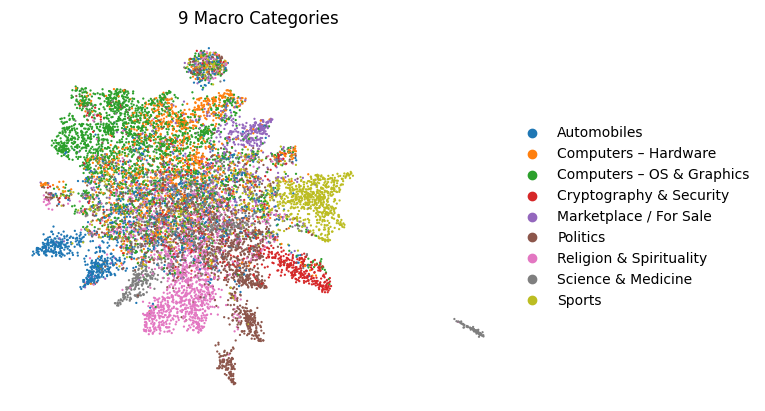

In [3]:
stop_words = set(stopwords.words("english"))

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
docs = data.data
labels = data.target
label_names = data.target_names

rows = []
for doc, label in tqdm(zip(docs, labels), total = len(labels)):
    words = doc.split()
    n_words = len(words)
    n_chars = len(doc)
    percent_stop = (sum(w.lower() in stop_words for w in words) / n_words) if n_words > 0 else 0.0

    rows.append({
        "n_words": n_words,
        "percent_stopwords": percent_stop,
        "n_chars": n_chars,
        "category": label_names[label],
    })

obs_df = pd.DataFrame(rows)

vectorizer = CountVectorizer(
    max_features=2000,  # vocabulary size
    stop_words="english",
)
X = vectorizer.fit_transform(docs)  # sparse matrix (n_docs × 2000 words)
vocab = vectorizer.get_feature_names_out()

adata = ad.AnnData(X)
adata.var_names = vocab
adata.obs = obs_df.copy()

sc.pp.normalize_total(adata) # library-size normalize
sc.pp.log1p(adata) # log transform
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var["highly_variable"]]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

# Mapping from 20 categories to 9 categories
macro_mapping = {
    "alt.atheism": "Religion & Spirituality",
    "soc.religion.christian": "Religion & Spirituality",
    "talk.religion.misc": "Religion & Spirituality",

    "comp.graphics": "Computers – OS & Graphics",
    "comp.os.ms-windows.misc": "Computers – OS & Graphics",
    "comp.windows.x": "Computers – OS & Graphics",
    "comp.sys.mac.hardware": "Computers – OS & Graphics",

    "comp.sys.ibm.pc.hardware": "Computers – Hardware",
    "sci.electronics": "Computers – Hardware",

    "sci.crypt": "Cryptography & Security",

    "rec.autos": "Automobiles",
    "rec.motorcycles": "Automobiles",

    "rec.sport.baseball": "Sports",
    "rec.sport.hockey": "Sports",

    "sci.space": "Science & Medicine",
    "sci.med": "Science & Medicine",

    "talk.politics.misc": "Politics",
    "talk.politics.guns": "Politics",
    "talk.politics.mideast": "Politics",

    "misc.forsale": "Marketplace / For Sale",
}


adata.obs["macro_category"] = adata.obs["category"].map(macro_mapping)

sc.pl.umap(
    adata,
    color="macro_category",
    title="9 Macro Categories",
    frameon=False,
)


In [4]:
coords = adata.obsm["X_umap"]        # shape (n_docs, 2)

X_counts = X                         # (n_docs, n_words)
n_docs, n_words = X_counts.shape

center_docs = coords.mean(axis=0)    # (2,)

if sp.issparse(X_counts):
    X_abs = X_counts.copy()
    X_abs.data = np.abs(X_abs.data)
    X_T = X_abs.T.tocsr()    # (n_words, n_docs)
    sum_weights = np.asarray(X_T.sum(axis=1)).ravel()
else:
    X_abs = np.abs(X_counts)
    X_T = X_abs.T
    sum_weights = X_abs.sum(axis=0)

nonzero_mask = sum_weights > 0

# UMAP coordonates
word_coords = np.zeros((n_words, 2), dtype=float)
word_coords[nonzero_mask] = (X_T @ coords)[nonzero_mask] / sum_weights[nonzero_mask][:, None]

# Distance of points from the center 
dists = np.linalg.norm(word_coords - center_docs[None, :], axis=1)

# q is the proportion of words to remove from the center
q = 0.5
valid_dists = dists[nonzero_mask]
threshold = np.quantile(valid_dists, q)

center_mask = (dists <= threshold)         
keep_mask   = (dists>threshold)               

center_words = vocab[center_mask]
print(f"{center_mask.sum()} mots au centre du UMAP (exemples) :")
print(center_words[:30])


1000 mots au centre du UMAP (exemples) :
['10' '100' '1000' '130' '15' '150' '16' '1988' '1989' '1990' '1991'
 '1992' '1993' '20' '200' '24' '250' '30' '300' '32' '400' '50' '500'
 '600' '800' '90' '91' '92' '93' '95']


In [5]:
# Filter matrix and vocabulary
X_filtered = X_counts[:, keep_mask]
vocab_filtered = vocab[keep_mask]

obs_df = pd.DataFrame(rows)

adata_filt = ad.AnnData(X_filtered)
adata_filt.var_names = vocab_filtered
adata_filt.obs = obs_df.copy()

# Macro-categories
adata_filt.obs["macro_category"] = adata_filt.obs["category"].map(macro_mapping)

sc.pp.scale(adata_filt, max_value=10)
sc.tl.pca(adata_filt)
sc.pp.neighbors(adata_filt, n_neighbors=15, n_pcs=50)

sc.tl.umap(adata_filt)

/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


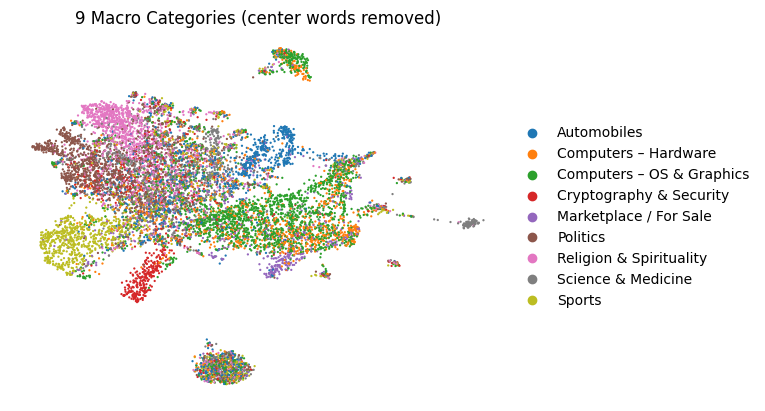

In [ ]:
# UMAP without center words
sc.pl.umap(
    adata_filt,
    color="macro_category",
    title="9 Macro Categories (center words removed)",
    frameon=False,
)


In [ ]:
input_distribution = ["G"] # Gaussian because normalized data
normalization_train = [np.ones(adata_filt.X.shape[0])]

model = maa.fit_MIDAA(
    [adata_filt.X], 
    normalization_train,
    input_distribution,lr=0.001,steps=900, narchetypes=5) 

deepAA = model["deepAA_obj"]
model_to_save = {
    "inferred_quantities": model["inferred_quantities"],
    "hyperparameters": model["hyperparameters"],
    "ELBO": model["ELBO"]
}

with open("model_save/model_3_metadata3.pkl", "wb") as f:
    pickle.dump(model_to_save, f)

torch.save(deepAA.state_dict(), "model_save/model_3_weights3.pt")

ELBO: 21299818.00000  : 100%|██████████| 900/900 [1:46:18<00:00,  7.09s/it]    


# II) Training

In [53]:
import pickle

model_to_save = {
        "inferred_quantities": model["inferred_quantities"],
        "hyperparameters": model["hyperparameters"],
        "ELBO": model["ELBO"]
    }
with open("further_test.pkl", "wb") as f:
        pickle.dump(model_to_save, f)

In [54]:
model["ELBO"][-1]

array(21667138., dtype=float32)

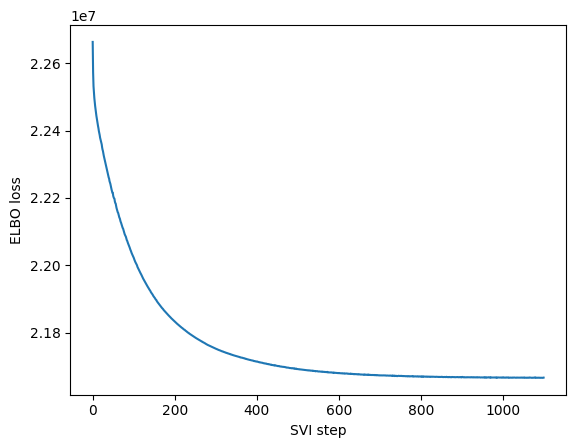

In [70]:
maa.plot_ELBO(model)

# III) Choose number of archetypes: Elbow Methods

In [93]:
input_distribution = ["G"] # Gaussian because normalized data
normalization_train = [np.ones(adata_filt.X.shape[0])]
models = {}

for i in tqdm(range(4, 8)): # Between 4 and 7 archetypes 
    model = maa.fit_MIDAA([adata_filt.X], normalization_train,input_distribution,lr=0.001,steps=900, narchetypes=i) 

    models[i]=model
    

    deepAA = model["deepAA_obj"]
    model_to_save = {
        "inferred_quantities": model["inferred_quantities"],
        "hyperparameters": model["hyperparameters"],
        "ELBO": model["ELBO"]
    }

    with open(f"model_save/model_{i}_metadata.pkl", "wb") as f:
        pickle.dump(model_to_save, f)

    torch.save(deepAA.state_dict(), f"model_save/model_{i}_weights.pt")

100%|██████████| 4/4 [58:04<00:00, 871.21s/it]


## Load Models

In [8]:
models = {}

for i in range(2, 8):
    model = {}
    with open(f"model_save/better_data/model_{i}_metadata.pkl", "rb") as f:
        model=pickle.load(f)

    model["deepAA_obj"] = torch.load(f"model_save/better_data/model_{i}_weights.pt")
    models[i]=model

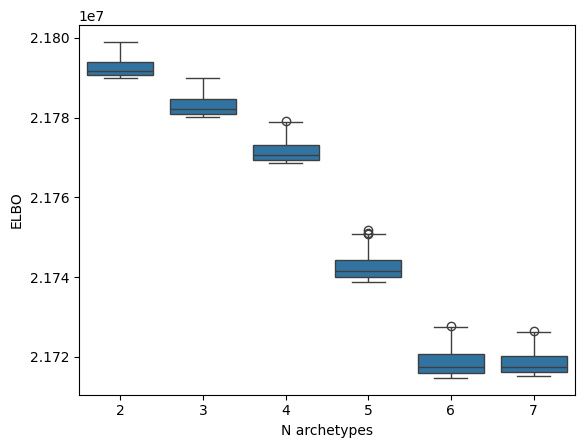

In [97]:
maa.plot_ELBO_across_runs(models, warmup=500)

Conclusion: 5 archetypes

# IV) Visualization

11314


(<Figure size 1500x1500 with 9 Axes>,
 array([<PolarAxes: title={'center': 'Group: Automobiles'}>,
        <PolarAxes: title={'center': 'Group: Computers – OS & Graphics'}>,
        <PolarAxes: title={'center': 'Group: Science & Medicine'}>,
        <PolarAxes: title={'center': 'Group: Politics'}>,
        <PolarAxes: title={'center': 'Group: Computers – Hardware'}>,
        <PolarAxes: title={'center': 'Group: Religion & Spirituality'}>,
        <PolarAxes: title={'center': 'Group: Marketplace / For Sale'}>,
        <PolarAxes: title={'center': 'Group: Sports'}>,
        <PolarAxes: title={'center': 'Group: Cryptography & Security'}>],
       dtype=object))

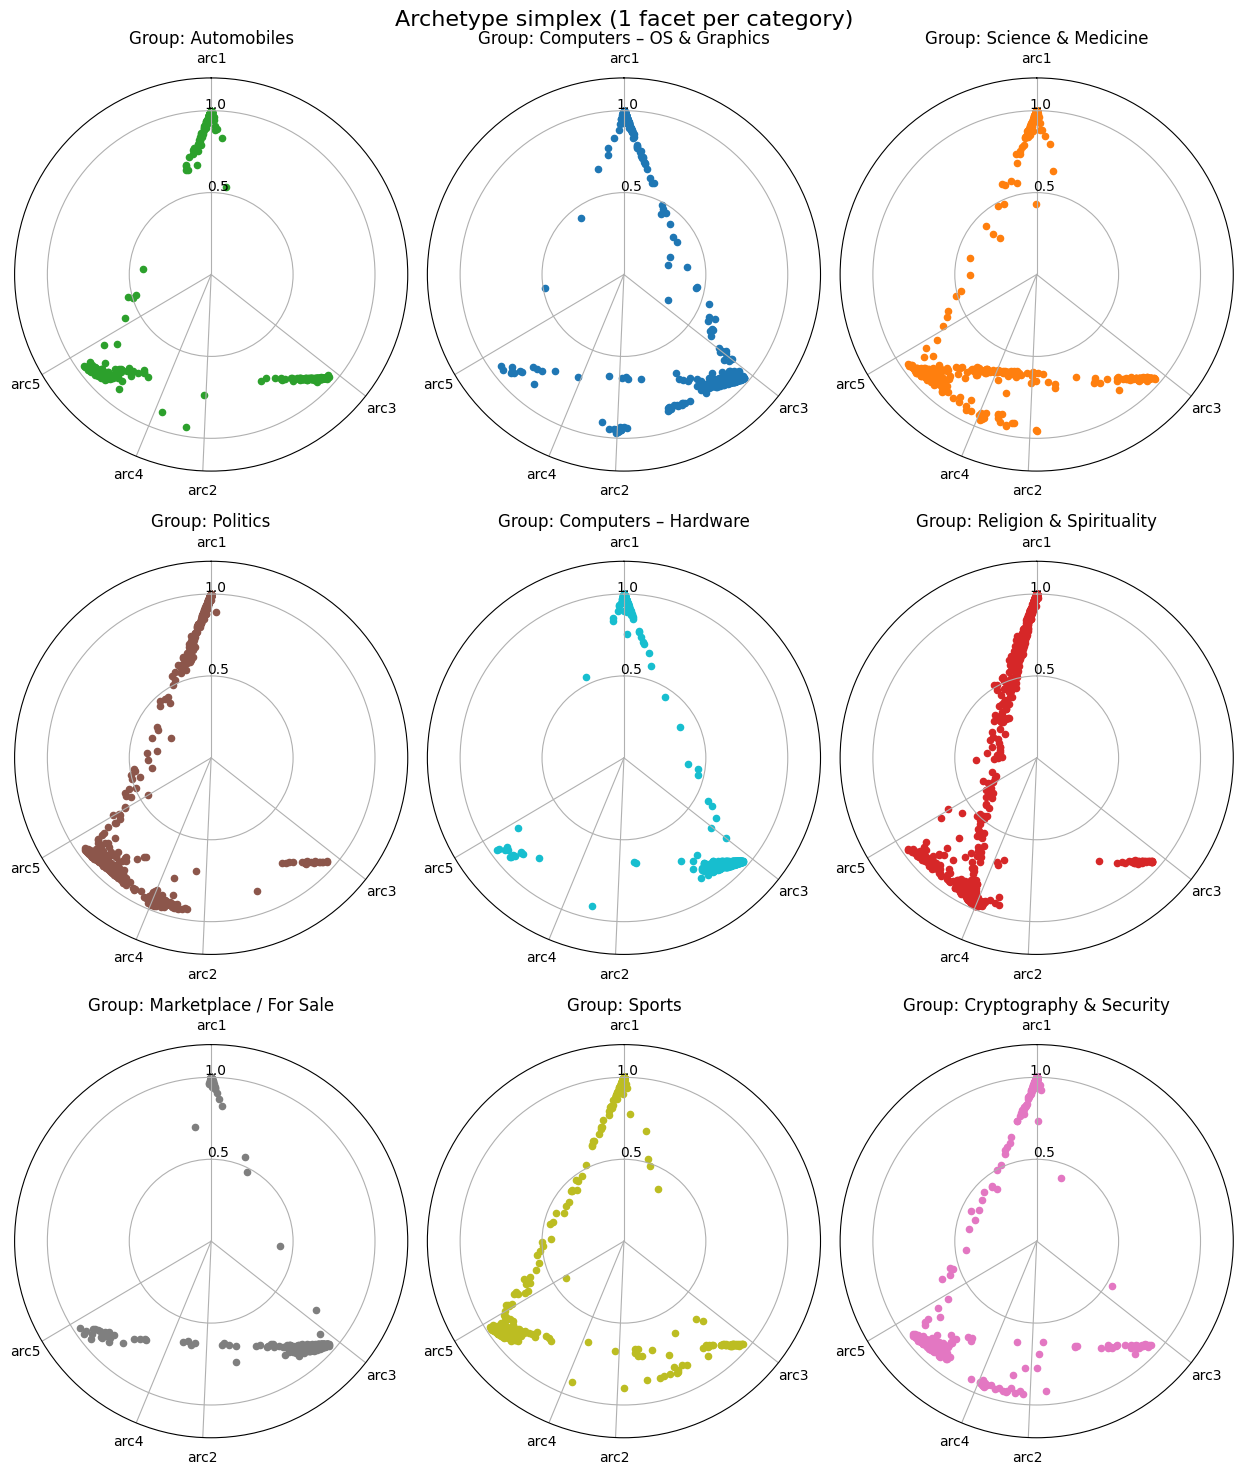

In [9]:
macro_palette = {
    "Computers – OS & Graphics": "#1f77b4",
    "Science & Medicine":        "#ff7f0e",
    "Automobiles":               "#2ca02c",
    "Religion & Spirituality":   "#d62728",
    "Politics":                  "#8c564b",
    "Cryptography & Security":   "#e377c2",
    "Marketplace / For Sale":    "#7f7f7f",
    "Sports":                    "#bcbd22",
    "Computers – Hardware":      "#17becf",
}

sums_midaa = adata_filt.X.sum(axis=1)

sums_adata  = np.asarray(adata_filt.X.sum(axis=1)).ravel()

mask_used = np.isin(sums_adata, sums_midaa)
mask_used.sum()

color_by_used = adata_filt.obs["macro_category"][mask_used].reset_index(drop=True)


def plot_archetypes_simplex_facets(
    res,
    distance_type="euclidean",
    cmap="nipy_spectral",
    color_by=None,
    subsample=None,
    s=20,
    figsize=(15, 15),
    l_title="Group"
):
    """
    Plot the data in the latent space in a 2d simplex
    """

    # Compute geometry (theta, r)
    if subsample is not None:
        arcs = res["inferred_quantities"]["A"][subsample, :]
    else:
        arcs = res["inferred_quantities"]["A"]

    dist_matrix = scipy.spatial.distance.cdist(arcs.T, arcs.T, distance_type)
    permutation, distance = solve_tsp_dynamic_programming(dist_matrix)

    dists = []
    for i in range(1, len(permutation)):
        dists.append(dist_matrix[permutation[i - 1], permutation[i]])
    dists.append(dist_matrix[permutation[-1], permutation[0]])
    dists = np.array(dists)
    dists /= dists.sum()

    labels = 360 * dists
    labels = labels.cumsum()[:-1]
    labels = np.append(0, labels)
    labels_rad = np.radians(labels)

    A = res["inferred_quantities"]["A"][:, permutation]

    r = np.sqrt((A * np.cos(labels_rad)).sum(axis=1)**2 +
                (A * np.sin(labels_rad)).sum(axis=1)**2)
    theta = np.arctan2(
        (A * np.sin(labels_rad)).sum(axis=1),
        (A * np.cos(labels_rad)).sum(axis=1)
    )

    arc_names = [f"arc{i+1}" for i in permutation]

    if color_by is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='polar')
        ax.scatter(theta, r, color="steelblue", s=s)
        ax.set_thetagrids(labels, arc_names)
        ax.set_rmax(1.2)
        ax.grid(True)
        return fig, ax

    # Multi-subplot: 1 per category
    unique_vals = list(color_by.unique())
    n = len(unique_vals)
    row_sums = np.asarray(adata_filt.X.sum(axis=1)).ravel()

    print(mask_used.sum())

    fig, axes = plt.subplots(
        3, 3,
        figsize=(figsize[0], figsize[1]),
        subplot_kw={"projection": "polar"}
    )
    axes = axes.flatten()

    color_map = macro_palette

    for ax, val in zip(axes, unique_vals):

        idx = color_by == val

        ax.scatter(theta[idx], r[idx], color=color_map[val], s=s)

        ax.set_thetagrids(labels, arc_names)
        ax.set_rmax(1.2)
        ax.set_rticks([0.5, 1])
        ax.set_rlabel_position(-2.5)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.grid(True)

        ax.set_title(f"{l_title}: {val}")

    fig.suptitle("Archetype simplex (1 facet per category)", fontsize=16)
    fig.subplots_adjust(top=0.2)
    plt.tight_layout()

    return fig, axes


plot_archetypes_simplex_facets(
    models[5],
    color_by=color_by_used)


/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


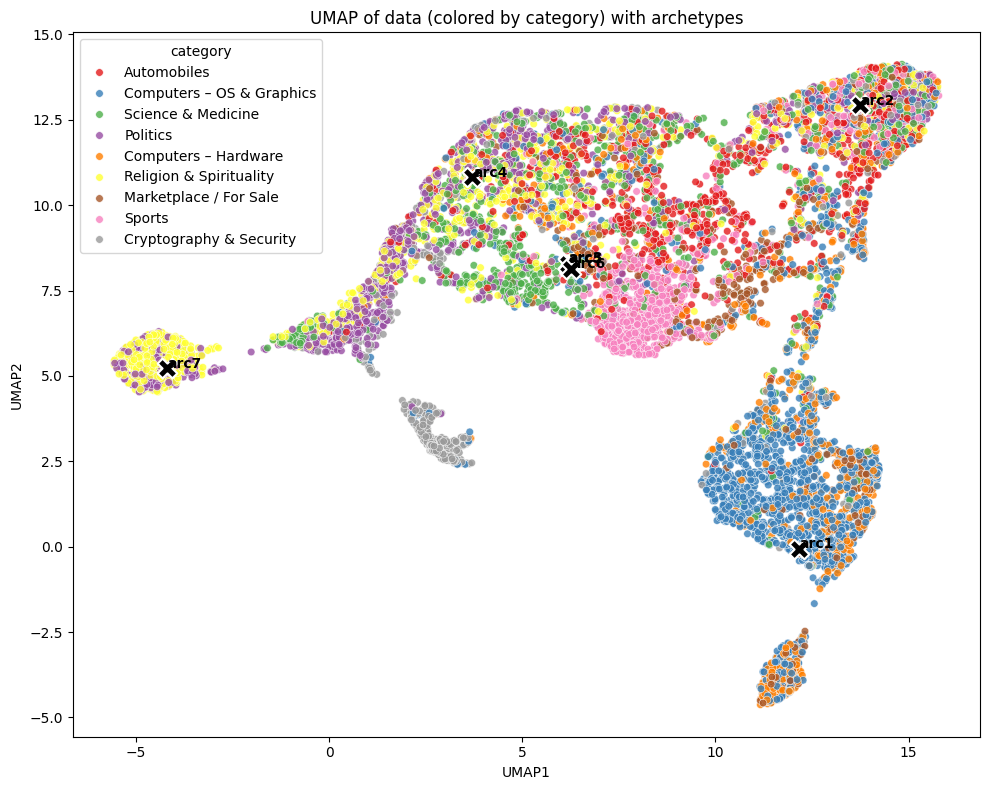

In [ ]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_data_and_archetypes(model, categories, palette="Set1",
                                  n_neighbors=15, min_dist=0.1, metric="euclidean"):
    """
    2D UMAP of the latent space   
    """
    Z = model["inferred_quantities"]["Z"]                    # (N, d)
    A = model["inferred_quantities"]["archetypes_inferred"]  # (K, d)

    N = Z.shape[0]
    K = A.shape[0]

    # Stack data + archetypes so UMAP learns a joint embedding
    X_all = np.vstack([Z, A])  

    # UMAP 2D
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_all = reducer.fit_transform(X_all)

    Z_umap = emb_all[:N]       
    A_umap = emb_all[N:]        

    df = pd.DataFrame({
        "UMAP1": Z_umap[:, 0],
        "UMAP2": Z_umap[:, 1],
        "category": categories.values
    })

    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=df,
        x="UMAP1",
        y="UMAP2",
        hue="category",
        palette=palette,
        alpha=0.8,
        s=30,
    )

    # Overlay archetypes
    sns.scatterplot(
        x=A_umap[:, 0],
        y=A_umap[:, 1],
        s=200,
        marker="X",
        color="black",
        edgecolor="white",
        linewidth=1.5,
        ax=ax,
        legend=False,
    )

    # label archetypes
    for i, (x, y) in enumerate(A_umap):
        plt.text(x + 0.02, y + 0.02, f"arc{i+1}", fontsize=10, weight="bold")

    plt.title("UMAP of data (colored by category) with archetypes")
    plt.tight_layout()
    return ax

ax = plot_umap_data_and_archetypes(
    model,
    categories=color_by_used,
    palette="Set1"
)

In [ ]:
def plot_umap3d_data_and_archetypes(
    model,
    categories,
    palette="Set1",
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    figsize=(10, 8)
):
    """
    3D UMAP of the latent space   
    """
     
    Z = model["inferred_quantities"]["Z"]
    A = model["inferred_quantities"]["archetypes_inferred"]

    N = Z.shape[0]
    K = A.shape[0]

    X_all = np.vstack([Z, A])

    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_all = reducer.fit_transform(X_all)

    Z_umap = emb_all[:N]
    A_umap = emb_all[N:]



    cats = pd.Series(categories).reset_index(drop=True)
    unique_cats = cats.unique()
    pal = sns.color_palette(palette, len(unique_cats))
    color_map = {cat: pal[i] for i, cat in enumerate(unique_cats)}
    point_colors = [color_map[c] for c in cats]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        Z_umap[:, 0], Z_umap[:, 1], Z_umap[:, 2],
        c=point_colors,
        s=20,
        alpha=0.8
    )

    ax.scatter(
        A_umap[:, 0], A_umap[:, 1], A_umap[:, 2],
        c="white",
        s=500,                 
        marker="X",
        linewidth=0,
        alpha=1.0,
        zorder=10
    )

    ax.scatter(
        A_umap[:, 0], A_umap[:, 1], A_umap[:, 2],
        c="black",
        s=350,
        marker="X",
        edgecolor="white",
        linewidth=2.5,
        zorder=11
    )

    for i, (x, y, z) in enumerate(A_umap):
        ax.text(
            x, y, z,
            f"arc{i+1}",
            fontsize=14,
            fontweight="bold",
            color="black",
            zorder=12
        )

    # legend
    for cat in unique_cats:
        ax.scatter([], [], [], c=[color_map[cat]], label=cat)
    ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")
    ax.set_title("UMAP 3D of Z with visible archetypes")

    plt.tight_layout()
    return fig, ax

    


/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


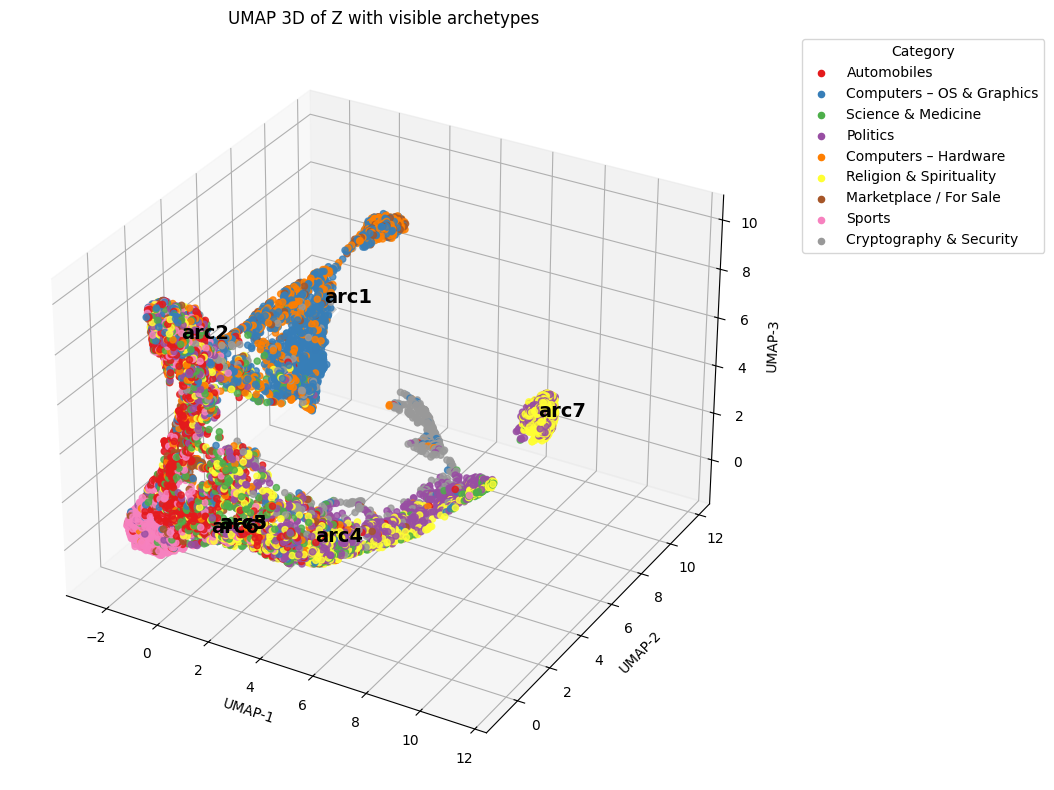

In [12]:
fig, ax = plot_umap3d_data_and_archetypes(
    model,
    categories=adata_filt.obs["macro_category"],
    palette="Set1"
)